# Gradient Descent Constant step size

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Defining function to generate Ybus, a voltage distribution for test bench and power crossponding to it 
#Generating Y buses and a test bench
def get_y(n, avg_conn, min_y, max_y):
    y_mat = np.zeros((n, n), dtype='complex128')
    for i in range(n):
        num_connections = min(np.random.poisson(avg_conn), n-1)
        connected_buses = np.random.choice([j for j in range(n) if j != i], size=num_connections, replace=False)

        y_mat[i, connected_buses] = (
            np.random.uniform(min_y, max_y, size=num_connections) -
            1j * np.random.uniform(min_y, max_y, size=num_connections)*2
        )
    y_mat = (y_mat + y_mat.T) / 2
    
    yy_mat = np.zeros((n, n), dtype='complex128')
    for i in range(n):
        for j in range(n):
            yy_mat[i][i] += y_mat[i][j]
            if(i!=j): yy_mat[i][j] = 0-y_mat[i][j]

    return yy_mat


def get_v(n, mag_high, mag_low, angle_high, angle_low):
    mag = np.random.rand(n, 1) * (mag_high - mag_low) + mag_low
    angles = np.random.rand(n, 1) * (angle_high - angle_low) + angle_low
    angles = np.deg2rad(angles)
    v = mag * np.exp(1j * angles)
    return v

def get_S(y, vr):
    S = vr*(np.conj(y)@np.conj(vr))
    
    return S

In [5]:
#Intializing the System with fixed number of buses and intial voltage distributation
N=20

n = N+1 #Total number of buses
avg_conn = 10 #Average connection
min_y, max_y = 5, 10
mag_high, mag_low = 1.05, 0.95
angle_high, angle_low = 10, 0


y = get_y(n, avg_conn, min_y, max_y) #Generating Y bus
Ybus = y[1:,1:] #Excluding Reference bus

v = get_v(n, mag_high, mag_low, angle_high, angle_low) #Intial voltage distribution
v[0] = 1 #Setting Reference bus
V = v[1:]

s = get_S(y, v) #Power corrosponding to intial distribution 

In [13]:
#Intial guess
VR = np.ones((1,N),dtype='complex128') #Voltage Row vector
VC = np.reshape(VR,(N,1)) #Voltage column vector
Sref = get_S(Ybus,V) #Reference Power or Schadule power

ss = 0.01 #Step size
itr = 30 #Number of iteration
Error = [] #Error per iteration




for i in range(itr):

    J1 = VR.conj()*Ybus #Jacabian crossponding to voltage conjuctate
    J2P = np.reshape(Ybus@VC,(N))
    J2  = np.diag(J2P) #Jacabian croosponding to voltage 

    #power calculation
    Jreal = J1 +J2 #Real voltage Jacobian
    Jimg = 1j*J1 - 1J*J2 #Imag voltage jacobian
    S = get_S(Ybus,VC)    
    delS = Sref - S #Power correction
    
    delR = np.real((delS.T)@Jreal) #Gradient real part of voltage
    delI = np.real((delS.T)@Jimg) #Gradient img part of voltage
    
    delVR = delR/np.linalg.norm(delR) # Increment Real voltage(*)
    delVI = delI/np.linalg.norm(delI) #Increment imag voltage
    
    VR = VR+ss*(delVR+1j*delVI) #Change voltage
    VC = np.reshape(VR,(N,1))
    
    S = get_S(Ybus,VC) #Power crossponding to new voltage
    error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    Error.append(error2)

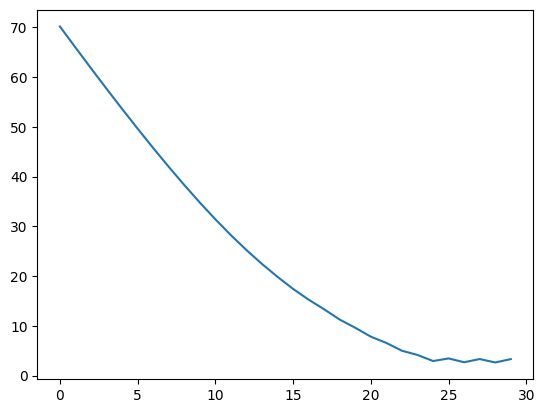

In [14]:
plt.plot(Error)